In [1]:
import numpy as np

def preprocess_fasta(fasta_file):
    """
    Read a FASTA file and encode the amino acid sequence into numerical indices.
    """
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}

    sequence = ""
    with open(fasta_file, "r") as f:
        for line in f:
            if not line.startswith(">"):
                sequence += line.strip()

    # Encode sequence as numerical indices
    encoded_sequence = [aa_to_idx[aa] for aa in sequence]
    return np.array(encoded_sequence), sequence

# Example FASTA file
fasta_file = "data/rcsb_pdb_8F0Y.fasta"  # Replace with your FASTA file path
encoded_sequence, raw_sequence = preprocess_fasta(fasta_file)
print("Encoded Sequence:", encoded_sequence)
print("Raw Sequence:", raw_sequence)


Encoded Sequence: [ 8  3 12  1 12 12  3 11  9 13  9 16 12 14  0  9 17  5  8 18 19  9 14 16
 16 15 12  2  7  4  8 13 17 15 11  7 16  3  4 19 15  0  6  5 11  2 19 19
  5 16 17 16  2 19 15 12  3 19  5  9  3  0  6 14 17 11  9 16 17 15  5 14
 16  9  8  4 19 10 11  2 16  6  3 19  2 15  8 19  3  7  9  0 17  2  8  2
 19  4  7  4 19  5  6 12 12  0  0 12 15  5  9  0  9  7  6 19 14 13 15  1
 12  8  3  2 17  7  8 14 17  8  8  0  9  8 11 17  1  9  2 19  8 19  4  5
 11  2 16 15 17 12  1  6 19 17  3]
Raw Sequence: KEPCPPENLQLTPRALVGKWYLRTTSPDIFKQVSNITEFYSAHGNDYYGTVTDYSPEYGLEAHRVNLTVSGRTLKFYMNDTHEYDSKYEILAVDKDYFIFYGHPPAAPSGLALIHYRQSCPKEDVIKRVKKALKNVCLDYKYFGNDTSVPCHYVE


In [2]:
import torch
import torch.nn as nn

class Protein3DModel(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
        super(Protein3DModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sequence):
        """
        Input: sequence (batch_size, seq_length)
        Output: 3D coordinates (batch_size, seq_length, 3)
        """
        x = self.embedding(sequence)  # (batch_size, seq_length, embed_dim)
        x, _ = self.lstm(x)           # (batch_size, seq_length, hidden_dim * 2)
        coords = self.fc(x)           # (batch_size, seq_length, 3)
        return coords


In [3]:
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    def __init__(self, encoded_sequence):
        self.sequence = torch.tensor(encoded_sequence, dtype=torch.long)

    def __len__(self):
        return 1  # Single protein sequence

    def __getitem__(self, idx):
        return self.sequence

# Create dataset and dataloader
dataset = ProteinDataset(encoded_sequence)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


In [4]:
# Generate random 3D coordinates as "ground truth"
true_coords = torch.rand(len(encoded_sequence), 3)

# Initialize model
input_dim = 20  # 20 amino acids
embed_dim = 64
hidden_dim = 128
output_dim = 3  # (x, y, z)
model = Protein3DModel(input_dim, embed_dim, hidden_dim, output_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):  # Number of epochs
    for sequence in dataloader:
        optimizer.zero_grad()
        predicted_coords = model(sequence)
        loss = criterion(predicted_coords.squeeze(0), true_coords)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")


Epoch 1: Loss = 0.2783
Epoch 2: Loss = 0.2262
Epoch 3: Loss = 0.1809
Epoch 4: Loss = 0.1420
Epoch 5: Loss = 0.1105
Epoch 6: Loss = 0.0885
Epoch 7: Loss = 0.0794
Epoch 8: Loss = 0.0842
Epoch 9: Loss = 0.0931
Epoch 10: Loss = 0.0947
Epoch 11: Loss = 0.0889
Epoch 12: Loss = 0.0809
Epoch 13: Loss = 0.0744
Epoch 14: Loss = 0.0707
Epoch 15: Loss = 0.0694
Epoch 16: Loss = 0.0693
Epoch 17: Loss = 0.0697
Epoch 18: Loss = 0.0699
Epoch 19: Loss = 0.0697
Epoch 20: Loss = 0.0689
Epoch 21: Loss = 0.0677
Epoch 22: Loss = 0.0661
Epoch 23: Loss = 0.0644
Epoch 24: Loss = 0.0628
Epoch 25: Loss = 0.0614
Epoch 26: Loss = 0.0602
Epoch 27: Loss = 0.0593
Epoch 28: Loss = 0.0587
Epoch 29: Loss = 0.0581
Epoch 30: Loss = 0.0576
Epoch 31: Loss = 0.0570
Epoch 32: Loss = 0.0563
Epoch 33: Loss = 0.0555
Epoch 34: Loss = 0.0546
Epoch 35: Loss = 0.0537
Epoch 36: Loss = 0.0528
Epoch 37: Loss = 0.0519
Epoch 38: Loss = 0.0511
Epoch 39: Loss = 0.0503
Epoch 40: Loss = 0.0495
Epoch 41: Loss = 0.0487
Epoch 42: Loss = 0.0479
E

C:\Users\sravy\AppData\Local\Temp\ipykernel_23380\3854844865.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predicted_coords = model(torch.tensor([encoded_sequence]))


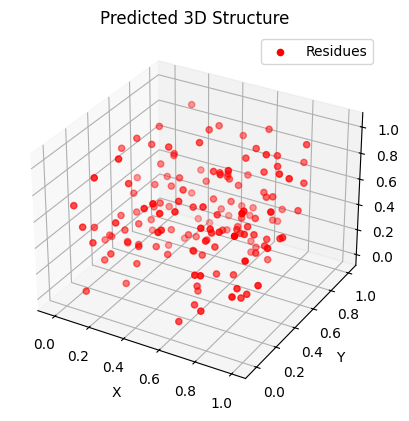

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_structure(coords, title="Predicted 3D Structure"):
    coords = coords.detach().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c="red", label="Residues")
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend()
    plt.show()

# Plot the predicted structure
predicted_coords = model(torch.tensor([encoded_sequence]))
plot_3d_structure(predicted_coords.squeeze(0))


In [6]:
def save_pdb(coords, sequence, output_file="predicted_structure.pdb"):
    """
    Save predicted coordinates as a PDB file with the correct residue names.
    
    Args:
        coords (torch.Tensor): Predicted 3D coordinates of shape (seq_length, 3).
        sequence (str): Raw amino acid sequence (single-letter code).
        output_file (str): File path to save the PDB file.
    """
    # Mapping of single-letter amino acids to three-letter codes
    aa_to_three_letter = {
        "A": "ALA", "C": "CYS", "D": "ASP", "E": "GLU", "F": "PHE",
        "G": "GLY", "H": "HIS", "I": "ILE", "K": "LYS", "L": "LEU",
        "M": "MET", "N": "ASN", "P": "PRO", "Q": "GLN", "R": "ARG",
        "S": "SER", "T": "THR", "V": "VAL", "W": "TRP", "Y": "TYR"
    }

    with open(output_file, "w") as f:
        for i, (x, y, z) in enumerate(coords.detach().numpy(), start=1):
            aa = aa_to_three_letter.get(sequence[i - 1], "UNK")  # Get three-letter code
            f.write(
                f"ATOM  {i:5d}  CA  {aa} A{i:4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           C\n"
            )
        f.write("TER\nEND\n")

# Save the predicted structure with the correct residue names
save_pdb(predicted_coords.squeeze(0), raw_sequence, "predicted_structure.pdb")
print("Predicted structure saved to predicted_structure.pdb")


Predicted structure saved to predicted_structure.pdb


In [7]:
import MDAnalysis as mda

# Load the reference and predicted PDB files
reference_pdb = "data/8f0y.pdb"  # Replace with your reference PDB path
predicted_pdb = "predicted_structure.pdb"  # Replace with your predicted PDB path

u_ref = mda.Universe(reference_pdb)
u_pred = mda.Universe(predicted_pdb)

# Select alpha carbons (backbone)
ref_atoms = u_ref.select_atoms("name CA")
pred_atoms = u_pred.select_atoms("name CA")

# Print residue IDs
print("Reference Residue IDs:", ref_atoms.residues.resids)
print("Predicted Residue IDs:", pred_atoms.residues.resids)


Reference Residue IDs: [  1   2   3   4   5   6  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154]
Predicted Residue IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85

In [8]:
# Find the overlapping residue IDs
overlap_resids = set(ref_atoms.residues.resids).intersection(pred_atoms.residues.resids)
print("Overlapping Residue IDs:", sorted(overlap_resids))

# Select atoms for overlapping residues
ref_overlap = u_ref.select_atoms(f"resid {' '.join(map(str, overlap_resids))} and name CA")
pred_overlap = u_pred.select_atoms(f"resid {' '.join(map(str, overlap_resids))} and name CA")

# Ensure the lengths now match
assert len(ref_overlap) == len(pred_overlap), "Mismatch after filtering overlapping residues!"


Overlapping Residue IDs: [1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]


In [9]:
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

# Align predicted structure to the reference using overlapping residues
alignment = align.AlignTraj(u_pred, u_ref, select=f"resid {' '.join(map(str, overlap_resids))} and name CA", in_memory=True)
alignment.run()

# Compute RMSD for overlapping residues
rmsd_value = rmsd(pred_overlap.positions, ref_overlap.positions, superposition=True)
print(f"RMSD for overlapping residues: {rmsd_value:.3f} Å")



RMSD for overlapping residues: 14.375 Å


C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\MDAnalysis\core\universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


In [10]:
# Save both structures for visualization
ref_atoms.write("reference_ca.pdb")
pred_atoms.write("predicted_ca_aligned.pdb")

print("Files saved for visualization: reference_ca.pdb, predicted_ca_aligned.pdb")


Files saved for visualization: reference_ca.pdb, predicted_ca_aligned.pdb


C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\MDAnalysis\coordinates\PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\MDAnalysis\coordinates\PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [14]:
# Print sequences from PDB
ref_sequence = "".join(ref_atoms.residues.resnames)
pred_sequence = "".join(pred_atoms.residues.resnames)

print("Reference Sequence:", ref_sequence)
print("Predicted Sequence:", pred_sequence)


Reference Sequence: LYSGLUPROCYSPROPROLEUTHRPROARGALALEUVALGLYLYSTRPTYRLEUARGTHRTHRSERPROASPILEPHELYSGLNVALSERASNILETHRGLUPHETYRSERALAHISGLYASNASPTYRTYRGLYTHRVALTHRASPTYRSERPROGLUTYRGLYLEUGLUALAHISARGVALASNLEUTHRVALSERGLYARGTHRLEULYSPHETYRMETASNASPTHRHISGLUTYRASPSERLYSTYRGLUILELEUALAVALASPLYSASPTYRPHEILEPHETYRGLYHISPROPROALAALAPROSERGLYLEUALALEUILEHISTYRARGGLNSERCYSPROLYSGLUASPVALILELYSARGVALLYSLYSALALEULYSASNVALCYSLEUASPTYRLYSTYRPHEGLYASNASPTHRSERVALPROCYSHISTYRVAL
Predicted Sequence: LYSGLUPROCYSPROPROGLUASNLEUGLNLEUTHRPROARGALALEUVALGLYLYSTRPTYRLEUARGTHRTHRSERPROASPILEPHELYSGLNVALSERASNILETHRGLUPHETYRSERALAHISGLYASNASPTYRTYRGLYTHRVALTHRASPTYRSERPROGLUTYRGLYLEUGLUALAHISARGVALASNLEUTHRVALSERGLYARGTHRLEULYSPHETYRMETASNASPTHRHISGLUTYRASPSERLYSTYRGLUILELEUALAVALASPLYSASPTYRPHEILEPHETYRGLYHISPROPROALAALAPROSERGLYLEUALALEUILEHISTYRARGGLNSERCYSPROLYSGLUASPVALILELYSARGVALLYSLYSALALEULYSASNVALCYSLEUASPTYRLYSTYRPHEGLYASNASPTHRSERVALPROCYSHISTYRVALGLU


In [15]:
from Bio import pairwise2

alignment = pairwise2.align.globalxx(ref_sequence, pred_sequence)
print(pairwise2.format_alignment(*alignment[0]))


LYSGLUPROCYSPROPRO-L-----EU------THRPROARGALALEUVALGLYLYSTRPTYRLEUARGTHRTHRSERPROASPILEPHELYSGLNVALSERASNILETHRGLUPHETYRSERALAHISGLYASNASPTYRTYRGLYTHRVALTHRASPTYRSERPROGLUTYRGLYLEUGLUALAHISARGVALASNLEUTHRVALSERGLYARGTHRLEULYSPHETYRMETASNASPTHRHISGLUTYRASPSERLYSTYRGLUILELEUALAVALASPLYSASPTYRPHEILEPHETYRGLYHISPROPROALAALAPROSERGLYLEUALALEUILEHISTYRARGGLNSERCYSPROLYSGLUASPVALILELYSARGVALLYSLYSALALEULYSASNVALCYSLEUASPTYRLYSTYRPHEGLYASNASPTHRSERVALPROCYSHISTYRVAL---
|||||||||||||||||| |     ||      |||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||   
LYSGLUPROCYSPROPROGLUASNLEUGLNLEUTHRPROARGALALEUVALGLYLYSTRPTYRLEUAR

In [23]:
from openmm.app import PDBFile, ForceField, Simulation
from openmm import LangevinIntegrator
from openmm.unit import picoseconds, kelvin, femtoseconds

# Load the predicted PDB file
pdb = PDBFile("predicted_ca_aligned.pdb")  # Replace with your file

# Load the force field (ensure the XML file is in your environment)
forcefield = ForceField("amber14-all.xml")

# Create the system
system = forcefield.createSystem(pdb.topology)

# Define the integrator
integrator = LangevinIntegrator(
    300 * kelvin,       # Temperature
    1 / picoseconds,    # Friction coefficient
    2 * femtoseconds    # Time step
)

# Set up the simulation
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)

# Minimize energy
print("Minimizing energy...")
simulation.minimizeEnergy()

# Save the refined structure
output_file = "refined_structure.pdb"
with open(output_file, "w") as f:
    PDBFile.writeFile(simulation.topology, simulation.context.getState(getPositions=True).getPositions(), f)

print(f"Refined structure saved to {output_file}")


ModuleNotFoundError: No module named 'openmm'

In [ ]:
import numpy as np

def preprocess_fasta(fasta_file):
    """
    Read a FASTA file and encode the amino acid sequence into numerical indices.
    """
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_idx = {aa: i for i, aa in enumerate(amino_acids)}

    sequence = ""
    with open(fasta_file, "r") as f:
        for line in f:
            if not line.startswith(">"):
                sequence += line.strip()

    # Encode sequence as numerical indices
    encoded_sequence = [aa_to_idx[aa] for aa in sequence]
    return np.array(encoded_sequence), sequence

# Example FASTA file
fasta_file = "data/rcsb_pdb_8F0Y.fasta"  # Replace with your FASTA file path
encoded_sequence, raw_sequence = preprocess_fasta(fasta_file)
print("Encoded Sequence:", encoded_sequence)
print("Raw Sequence:", raw_sequence)


Encoded Sequence: [ 8  3 12  1 12 12  3 11  9 13  9 16 12 14  0  9 17  5  8 18 19  9 14 16
 16 15 12  2  7  4  8 13 17 15 11  7 16  3  4 19 15  0  6  5 11  2 19 19
  5 16 17 16  2 19 15 12  3 19  5  9  3  0  6 14 17 11  9 16 17 15  5 14
 16  9  8  4 19 10 11  2 16  6  3 19  2 15  8 19  3  7  9  0 17  2  8  2
 19  4  7  4 19  5  6 12 12  0  0 12 15  5  9  0  9  7  6 19 14 13 15  1
 12  8  3  2 17  7  8 14 17  8  8  0  9  8 11 17  1  9  2 19  8 19  4  5
 11  2 16 15 17 12  1  6 19 17  3]
Raw Sequence: KEPCPPENLQLTPRALVGKWYLRTTSPDIFKQVSNITEFYSAHGNDYYGTVTDYSPEYGLEAHRVNLTVSGRTLKFYMNDTHEYDSKYEILAVDKDYFIFYGHPPAAPSGLALIHYRQSCPKEDVIKRVKKALKNVCLDYKYFGNDTSVPCHYVE


In [ ]:
import torch
import torch.nn as nn

class Protein3DModel(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_dim, output_dim):
        super(Protein3DModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, sequence):
        """
        Input: sequence (batch_size, seq_length)
        Output: 3D coordinates (batch_size, seq_length, 3)
        """
        x = self.embedding(sequence)  # (batch_size, seq_length, embed_dim)
        x, _ = self.lstm(x)           # (batch_size, seq_length, hidden_dim * 2)
        coords = self.fc(x)           # (batch_size, seq_length, 3)
        return coords


In [ ]:
from torch.utils.data import Dataset, DataLoader

class ProteinDataset(Dataset):
    def __init__(self, encoded_sequence):
        self.sequence = torch.tensor(encoded_sequence, dtype=torch.long)

    def __len__(self):
        return 1  # Single protein sequence

    def __getitem__(self, idx):
        return self.sequence

# Create dataset and dataloader
dataset = ProteinDataset(encoded_sequence)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)


In [ ]:
# Generate random 3D coordinates as "ground truth"
true_coords = torch.rand(len(encoded_sequence), 3)

# Initialize model
input_dim = 20  # 20 amino acids
embed_dim = 64
hidden_dim = 128
output_dim = 3  # (x, y, z)
model = Protein3DModel(input_dim, embed_dim, hidden_dim, output_dim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):  # Number of epochs
    for sequence in dataloader:
        optimizer.zero_grad()
        predicted_coords = model(sequence)
        loss = criterion(predicted_coords.squeeze(0), true_coords)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch + 1}: Loss = {loss.item():.4f}")


Epoch 1: Loss = 0.2783
Epoch 2: Loss = 0.2262
Epoch 3: Loss = 0.1809
Epoch 4: Loss = 0.1420
Epoch 5: Loss = 0.1105
Epoch 6: Loss = 0.0885
Epoch 7: Loss = 0.0794
Epoch 8: Loss = 0.0842
Epoch 9: Loss = 0.0931
Epoch 10: Loss = 0.0947
Epoch 11: Loss = 0.0889
Epoch 12: Loss = 0.0809
Epoch 13: Loss = 0.0744
Epoch 14: Loss = 0.0707
Epoch 15: Loss = 0.0694
Epoch 16: Loss = 0.0693
Epoch 17: Loss = 0.0697
Epoch 18: Loss = 0.0699
Epoch 19: Loss = 0.0697
Epoch 20: Loss = 0.0689
Epoch 21: Loss = 0.0677
Epoch 22: Loss = 0.0661
Epoch 23: Loss = 0.0644
Epoch 24: Loss = 0.0628
Epoch 25: Loss = 0.0614
Epoch 26: Loss = 0.0602
Epoch 27: Loss = 0.0593
Epoch 28: Loss = 0.0587
Epoch 29: Loss = 0.0581
Epoch 30: Loss = 0.0576
Epoch 31: Loss = 0.0570
Epoch 32: Loss = 0.0563
Epoch 33: Loss = 0.0555
Epoch 34: Loss = 0.0546
Epoch 35: Loss = 0.0537
Epoch 36: Loss = 0.0528
Epoch 37: Loss = 0.0519
Epoch 38: Loss = 0.0511
Epoch 39: Loss = 0.0503
Epoch 40: Loss = 0.0495
Epoch 41: Loss = 0.0487
Epoch 42: Loss = 0.0479
E

C:\Users\sravy\AppData\Local\Temp\ipykernel_23380\3854844865.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predicted_coords = model(torch.tensor([encoded_sequence]))


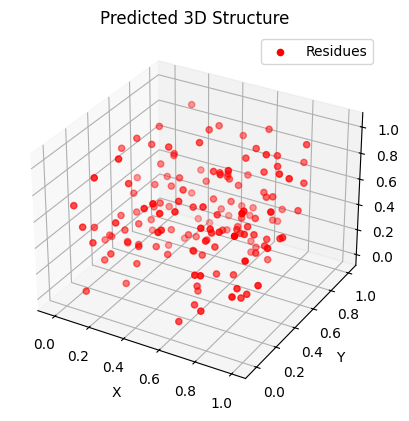

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_structure(coords, title="Predicted 3D Structure"):
    coords = coords.detach().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c="red", label="Residues")
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend()
    plt.show()

# Plot the predicted structure
predicted_coords = model(torch.tensor([encoded_sequence]))
plot_3d_structure(predicted_coords.squeeze(0))


In [ ]:
def save_pdb(coords, sequence, output_file="predicted_structure.pdb"):
    """
    Save predicted coordinates as a PDB file with the correct residue names.
    
    Args:
        coords (torch.Tensor): Predicted 3D coordinates of shape (seq_length, 3).
        sequence (str): Raw amino acid sequence (single-letter code).
        output_file (str): File path to save the PDB file.
    """
    # Mapping of single-letter amino acids to three-letter codes
    aa_to_three_letter = {
        "A": "ALA", "C": "CYS", "D": "ASP", "E": "GLU", "F": "PHE",
        "G": "GLY", "H": "HIS", "I": "ILE", "K": "LYS", "L": "LEU",
        "M": "MET", "N": "ASN", "P": "PRO", "Q": "GLN", "R": "ARG",
        "S": "SER", "T": "THR", "V": "VAL", "W": "TRP", "Y": "TYR"
    }

    with open(output_file, "w") as f:
        for i, (x, y, z) in enumerate(coords.detach().numpy(), start=1):
            aa = aa_to_three_letter.get(sequence[i - 1], "UNK")  # Get three-letter code
            f.write(
                f"ATOM  {i:5d}  CA  {aa} A{i:4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           C\n"
            )
        f.write("TER\nEND\n")

# Save the predicted structure with the correct residue names
save_pdb(predicted_coords.squeeze(0), raw_sequence, "predicted_structure.pdb")
print("Predicted structure saved to predicted_structure.pdb")


Predicted structure saved to predicted_structure.pdb


In [ ]:
import MDAnalysis as mda

# Load the reference and predicted PDB files
reference_pdb = "data/8f0y.pdb"  # Replace with your reference PDB path
predicted_pdb = "predicted_structure.pdb"  # Replace with your predicted PDB path

u_ref = mda.Universe(reference_pdb)
u_pred = mda.Universe(predicted_pdb)

# Select alpha carbons (backbone)
ref_atoms = u_ref.select_atoms("name CA")
pred_atoms = u_pred.select_atoms("name CA")

# Print residue IDs
print("Reference Residue IDs:", ref_atoms.residues.resids)
print("Predicted Residue IDs:", pred_atoms.residues.resids)


Reference Residue IDs: [  1   2   3   4   5   6  11  12  13  14  15  16  17  18  19  20  21  22
  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154]
Predicted Residue IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85

In [ ]:
# Find the overlapping residue IDs
overlap_resids = set(ref_atoms.residues.resids).intersection(pred_atoms.residues.resids)
print("Overlapping Residue IDs:", sorted(overlap_resids))

# Select atoms for overlapping residues
ref_overlap = u_ref.select_atoms(f"resid {' '.join(map(str, overlap_resids))} and name CA")
pred_overlap = u_pred.select_atoms(f"resid {' '.join(map(str, overlap_resids))} and name CA")

# Ensure the lengths now match
assert len(ref_overlap) == len(pred_overlap), "Mismatch after filtering overlapping residues!"


Overlapping Residue IDs: [1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]


In [ ]:
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

# Align predicted structure to the reference using overlapping residues
alignment = align.AlignTraj(u_pred, u_ref, select=f"resid {' '.join(map(str, overlap_resids))} and name CA", in_memory=True)
alignment.run()

# Compute RMSD for overlapping residues
rmsd_value = rmsd(pred_overlap.positions, ref_overlap.positions, superposition=True)
print(f"RMSD for overlapping residues: {rmsd_value:.3f} Å")



RMSD for overlapping residues: 14.375 Å


C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\MDAnalysis\core\universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


In [ ]:
# Save both structures for visualization
ref_atoms.write("reference_ca.pdb")
pred_atoms.write("predicted_ca_aligned.pdb")

print("Files saved for visualization: reference_ca.pdb, predicted_ca_aligned.pdb")


Files saved for visualization: reference_ca.pdb, predicted_ca_aligned.pdb


C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\MDAnalysis\coordinates\PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
C:\Users\sravy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\MDAnalysis\coordinates\PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [ ]:
# Print sequences from PDB
ref_sequence = "".join(ref_atoms.residues.resnames)
pred_sequence = "".join(pred_atoms.residues.resnames)

print("Reference Sequence:", ref_sequence)
print("Predicted Sequence:", pred_sequence)


Reference Sequence: LYSGLUPROCYSPROPROLEUTHRPROARGALALEUVALGLYLYSTRPTYRLEUARGTHRTHRSERPROASPILEPHELYSGLNVALSERASNILETHRGLUPHETYRSERALAHISGLYASNASPTYRTYRGLYTHRVALTHRASPTYRSERPROGLUTYRGLYLEUGLUALAHISARGVALASNLEUTHRVALSERGLYARGTHRLEULYSPHETYRMETASNASPTHRHISGLUTYRASPSERLYSTYRGLUILELEUALAVALASPLYSASPTYRPHEILEPHETYRGLYHISPROPROALAALAPROSERGLYLEUALALEUILEHISTYRARGGLNSERCYSPROLYSGLUASPVALILELYSARGVALLYSLYSALALEULYSASNVALCYSLEUASPTYRLYSTYRPHEGLYASNASPTHRSERVALPROCYSHISTYRVAL
Predicted Sequence: LYSGLUPROCYSPROPROGLUASNLEUGLNLEUTHRPROARGALALEUVALGLYLYSTRPTYRLEUARGTHRTHRSERPROASPILEPHELYSGLNVALSERASNILETHRGLUPHETYRSERALAHISGLYASNASPTYRTYRGLYTHRVALTHRASPTYRSERPROGLUTYRGLYLEUGLUALAHISARGVALASNLEUTHRVALSERGLYARGTHRLEULYSPHETYRMETASNASPTHRHISGLUTYRASPSERLYSTYRGLUILELEUALAVALASPLYSASPTYRPHEILEPHETYRGLYHISPROPROALAALAPROSERGLYLEUALALEUILEHISTYRARGGLNSERCYSPROLYSGLUASPVALILELYSARGVALLYSLYSALALEULYSASNVALCYSLEUASPTYRLYSTYRPHEGLYASNASPTHRSERVALPROCYSHISTYRVALGLU
